In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

### Recurrent autoencoder

In [6]:
from ConvLSTMCell import *

class SpatialConvAE2(nn.Module):
    def __init__(self, inchannels, nlayers, layerchans):
        super().__init__()
        self.inchannels = inchannels
        self.layerchans = layerchans
        
        conv_params = [(inchannels, layerchans, 8, 2),    # (-1, layerchans, 125, 125)
                       (layerchans, layerchans, 7, 2),    # (-1, layerchans, 60, 60)
                       (layerchans, layerchans, 8, 2)]    # (-1, layerchans, 27, 27)
                       
        encoder_modules = []
        for params in conv_params[:nlayers]:
            encoder_modules.append(nn.Conv2d(params[0], params[1], kernel_size=params[2], stride=params[3]))
            encoder_modules.append(nn.ReLU())
        self.encoder_convs = nn.Sequential(*encoder_modules)
                       
        decoder_modules = []
        for params in conv_params[:nlayers][::-1]:
            decoder_modules.append(nn.ConvTranspose2d(params[1], params[0], kernel_size=params[2], stride=params[3]))
            decoder_modules.append(nn.ReLU())
        self.decoder_convs = nn.Sequential(*decoder_modules)
        
    def encode(self, x):
        return self.encoder_convs(x)
    
    def decode(self, x):
        return self.decoder_convs(x)

class RConvAE(nn.Module):
    def __init__(self, inchannels, hidden_dim, nlayers_spatial, nchannels_spatial, inputnlayers_temporal, nchannels_temporal):
        super().__init__()
        
        self.spatial_AE = SpatialConvAE2(inchannels, nlayers_spatial, nchannels_spatial)
        
        self.encoder = nn.Sequential(ConvLSTMCell(8, hidden_dim),
                                     ConvLSTMCell(8, hidden_dim))
        
    def forward(self, x):
        x = self.spatial_AE.encode(x)
        # Todo

##  Comparison of methods for 30 seconds video

### PCA

In [4]:
video = VideoLoader('data_generated/R25_gray_scaled.mp4', gray=True, duration=10, torch=False)
all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

model_pca = custom_pca(10)
model_pca.fit(all_frames)

reconstructed = video.reduce_latent(model_pca)
print('L2-error of reconstruction:', reconstruction_error(reconstructed, all_frames.reshape(video.duration_frames, video.height, video.width)))

L2-error of reconstruction: 4.31239583539246


In [31]:
write_video('data_generated/week7/R25_pca_10comp.mp4', reconstructed, video)

### Autoencoders

In [6]:
models = torch.load('data_generated/week7/models.pth', map_location=torch.device('cpu'))

## Models

In [112]:
video_train = VideoLoader('data/experience/R25/R25_gray_scaled.mp4', duration=30, gray=True)
video_test =  VideoLoader('data/experience/R25/R25_gray_scaled.mp4', start=30, duration=10, gray=True)
meta = {'w': video_train.width, 
        'h': video_train.height,
        'fps': video_train.fps,
        'bs': video_train.batch_size,
        'gray': video_train.gray}
args = [((1, meta['w'], meta['h']), 50), ((1, meta['h'], meta['w']), 10), 
        (1, 2, 32), (1, 2, 32, 10)]
model_constructors = [PCAAutoEncoder, OneHAutoEncoder, TemporalConvAE, TemporalConvAE]
for m, a in zip(model_constructors, args):
    print(m(*a))
    print('-'*70)

PCAAutoEncoder(
  (to_lower_rep): Linear(in_features=65536, out_features=50, bias=True)
  (from_lower_rep): Linear(in_features=50, out_features=65536, bias=True)
)
----------------------------------------------------------------------
OneHAutoEncoder(
  (to_lower_rep): Sequential(
    (0): Linear(in_features=65536, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
  (from_lower_rep): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=65536, bias=True)
  )
)
----------------------------------------------------------------------
TemporalConvAE(
  (encoder_convs): Sequential(
    (0): Conv3d(1, 32, kernel_size=(8, 8, 8), stride=(2, 2, 2))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(5, 7, 7), stride=(1, 2, 2))
    (3): ReLU()
  )
  (decoder_convs): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(5, 7, 7), stride=(1, 2, 2))
    (1

In [2]:
def train_helper(model_key, base_model, model_args, video, lrs, models, num_epoch_tune=10, num_epoch=40):
    iteration_per_epoch = int(video.duration_frames/video.batch_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device', device)
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        
    losses_tune = []
    for lr in lrs:
        if len(lrs) == 1:
            losses_tune.append(0)
            break
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = base_model(*model_args).to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range(num_epoch_tune):
            epoch_loss = 0
            for frames in video:
                frames = frames.to(device)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        losses_tune.append(epoch_loss / iteration_per_epoch)
        if len(losses_tune) >= 2 and losses_tune[-1] > losses_tune[-2]:
            break
    lr = lrs[np.argmin(losses_tune)]
    print('Chosen learning rate:', lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = base_model(*model_args).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    t1 = time()
    losses = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            reconstructed = model(frames)
            loss = crit(frames, reconstructed)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / iteration_per_epoch)
        if (epoch+1) % 3 == 0:
            print(f'\t Error at epoch {epoch+1}:', losses[-1])
    
    model_dict = {
        'model': model.state_dict(),
        'epoch': num_epoch,
        'optimizer': optimizer.state_dict(),
        'lr': lr,
        'losses_tune': losses_tune,
        'lrs': lrs,
        'losses': losses,
        'epoch_time': (time()-t1)/num_epoch
    }
    models[model_key] = model_dict
    return model

def evaluate_model(model, model_key, models, meta):
    reconstructed_train = video_train.reduce_latent(model, trans=False)
    reconstructed_test = video_test.reduce_latent(model, trans=False)
    original_frames_train_ = original_frames_train.numpy().reshape(-1, *video_train.sample_shape)
    original_frames_test_  = original_frames_test.numpy().reshape(-1, *video_test.sample_shape)
    models[key]['train_error'] = reconstruction_error(original_frames_train_, reconstructed_train.numpy())
    models[key]['test_error'] = reconstruction_error(original_frames_test_, reconstructed_test.numpy())
    print('Training error:', models[key]['train_error'])
    print('Testing error:', models[key]['test_error'])
    reconstructed_train_ = reconstructed_train.numpy().reshape(-1, video_train.height, video_train.width)
    write_video(key+'.mp4', reconstructed_train_, meta['w'], meta['h'], meta['fps'], meta['gray'])
    print('Video for '+key+' written')

video_train = VideoLoader('R25_gray_scaled.mp4', duration=30, gray=True)
video_test =  VideoLoader('R25_gray_scaled.mp4', start=30, duration=10, gray=True)
meta = {'w': video_train.width, 
        'h': video_train.height,
        'fps': video_train.fps,
        'bs': video_train.batch_size,
        'gray': video_train.gray}
original_frames_train = video_train.get_all_frames()
original_frames_test = video_test.get_all_frames()
num_epoch, num_epoch_tune = 40, 10
models = {}

#### Results

In [93]:
models = torch.load('data_generated/week7/models.pth', map_location=torch.device('cpu'))

In [96]:
losses = [m['losses'] for m in models.values()]
max_epoch = max([m['epoch'] for m in models.values()])
losses.append([4.559068042234817]*max_epoch)
xs = [range(1, m['epoch']+1) for m in models.values()] + [range(1, max_epoch+1)]
labels = [l for l in models.keys()] + ['PCA']

Final error for 10-TempConvAE:
	Training: 16.865911
	Testing: 18.43578

Final error for 50-PCAAE:
	Training: 31.42559
	Testing: 30.344513

Final error for 10-OneHAE:
	Training: 14.447613
	Testing: 15.870127

Final error for TempConvAE:
	Training: 10.37117
	Testing: 10.157935



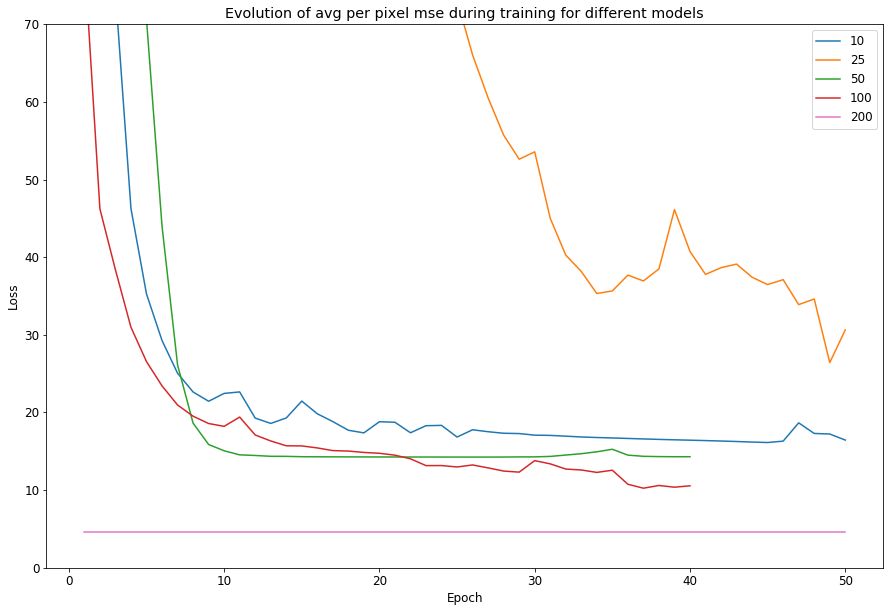

In [107]:
plot(xs, losses, labels=labels, title="Evolution of avg per pixel mse during training of 30 seconds of experience video",
    xlabel='Epoch', ylabel='Loss', yrange=(0, 70))
plt.savefig('data_generated/week7/losses_all_models.png')
for k, m in models.items():
    print('Final error for %s:' % k)
    print('\tTraining:', m['train_error'])
    print('\tTesting:', m['test_error'])
    print()

## Spatio-temporal convolutional autoencoder, latent dimension comparison

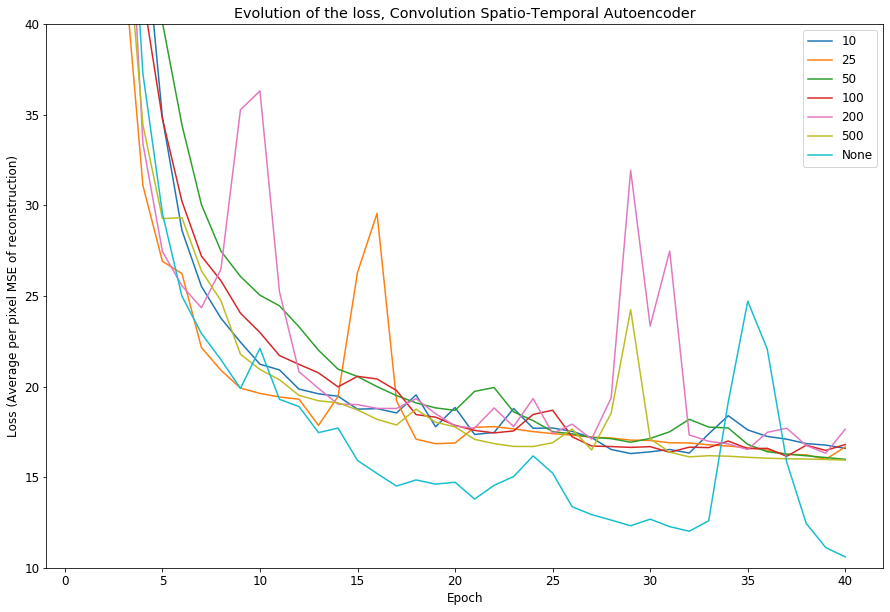

In [104]:
with open('data_generated/all_losses_from_colab_2.json', 'r') as fp:
    all_losses = json.load(fp)

ys = [l for _, l in all_losses.values()]
labels = [l for l in all_losses.keys()]

plot(range(1, 41), ys, labels=labels, yrange=(10, 40), 
     title='Evolution of the loss, Convolution Spatio-Temporal Autoencoder', xlabel='Epoch', ylabel='Loss (Average per pixel MSE of reconstruction)')
plt.savefig('data_generated/week7/losses_latent_dim.png')

## Loss with gradient

In [84]:
data = next(iter(VideoLoader('data/experience/R25/R25.mp4', gray=True, duration=2, batch_size=1, scale=(540, 360))))
im1 = np.array(data[0][0]).astype(np.uint8)

def gradient(x):
    # idea from tf.image.image_gradients(image)
    # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
    # x: (b,c,h,w), float32 or float64
    # dx, dy: (b,c,h,w)

    h_x = x.size()[-2]
    w_x = x.size()[-1]
    # gradient step=1
    left = x
    right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
    top = x
    bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

    dx, dy = right - left, bottom - top 
    dx[:, :, :, -1] = 0
    dy[:, :, -1, :] = 0

    return dx, dy

dx, dy = gradient(data)
grad_norm = torch.sqrt(dx**2 + dy**2).squeeze().numpy()
grad_norm = np.clip(grad_norm, 0, 255).astype(np.uint8)
im2 = grad_norm

loop = [im1, im2]
loop = 3*loop
for im in loop:
    cv2.imshow('', im)
    if cv2.waitKey(1000) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows()

In [87]:
def crit_with_gradient(x, x_true):
    alpha = 0.5
    
    mse = np.sqrt(np.mean((x-x_true)**2))
    
    dx, dy = gradient(x)
    dx_true, dy_true = gradient(x_true)
    
    mse_grad = ((dx-dx_true).abs() + (dy-dy_true).abs())
    
    return mse + mse_grad * alpha

### Week 5 plots

#### Time on CPU comparison

In [2]:
video = VideoLoader('data/experience/R25/R25_gray_scaled.mp4', duration=10, gray=True, randit=True)
iteration_per_epoch = int(video.duration_frames/video.batch_size)

times = []
for i, nlayers in enumerate(range(1,6)):
    times.append([])
    for layerchans in [4, 8, 12, 32, 64]:
        model = TemporalConvAE(1, nlayers, layerchans)
        start = time()
        
        reconstructed = []
        for frames in video:
            reconstructed.append(model(frames.view(1, 1, video.batch_size, video.height, video.width)).detach())
        reconstructed = torch.cat(reconstructed, 0)
            
        times[i].append(time()-start)

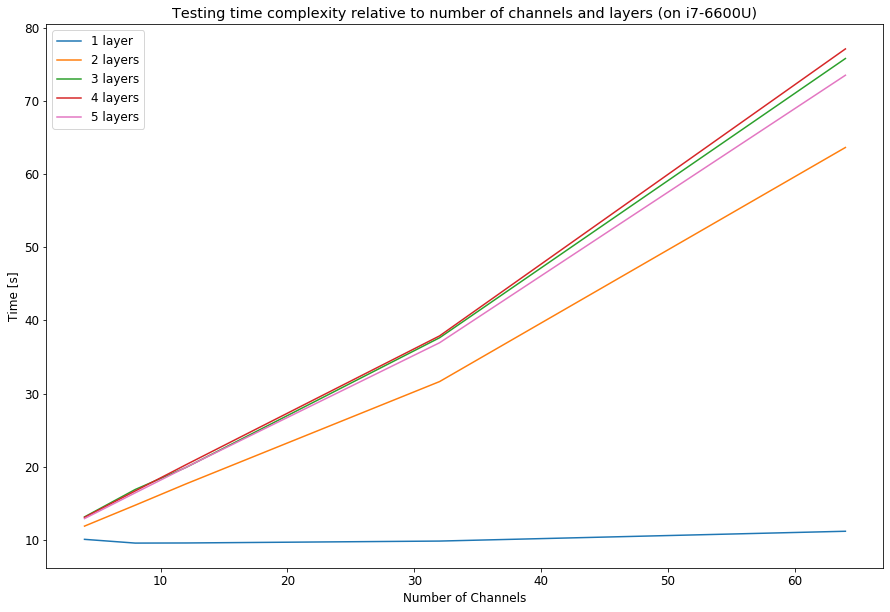

In [8]:
labels = [f'{i} layers' for i in range(1, 6)]
labels[0] = labels[0][:-1]
plot([4, 8, 12, 32, 64], times, labels=labels, title='Testing time complexity relative to number of channels and layers (on i7-6600U)', xlabel='Number of Channels', ylabel='Time [s]')
plt.savefig('data_generated/week5_test_time.png')

#### Colab

In [16]:
with open('data_generated/all_losses_from_colab.json', 'r') as fp:
    all_losses = json.load(fp)
with open('data_generated/all_losses_from_colab2.json', 'r') as fp:
    all_losses.update(json.load(fp))
all_losses = dict(sorted(all_losses.items()))
all_losses = {f'{l},{c}': all_losses[f'{l},{c}'] for l in [1,2,3,4,5] for c in [4,8,12,32,64]}

num_epoch = 30

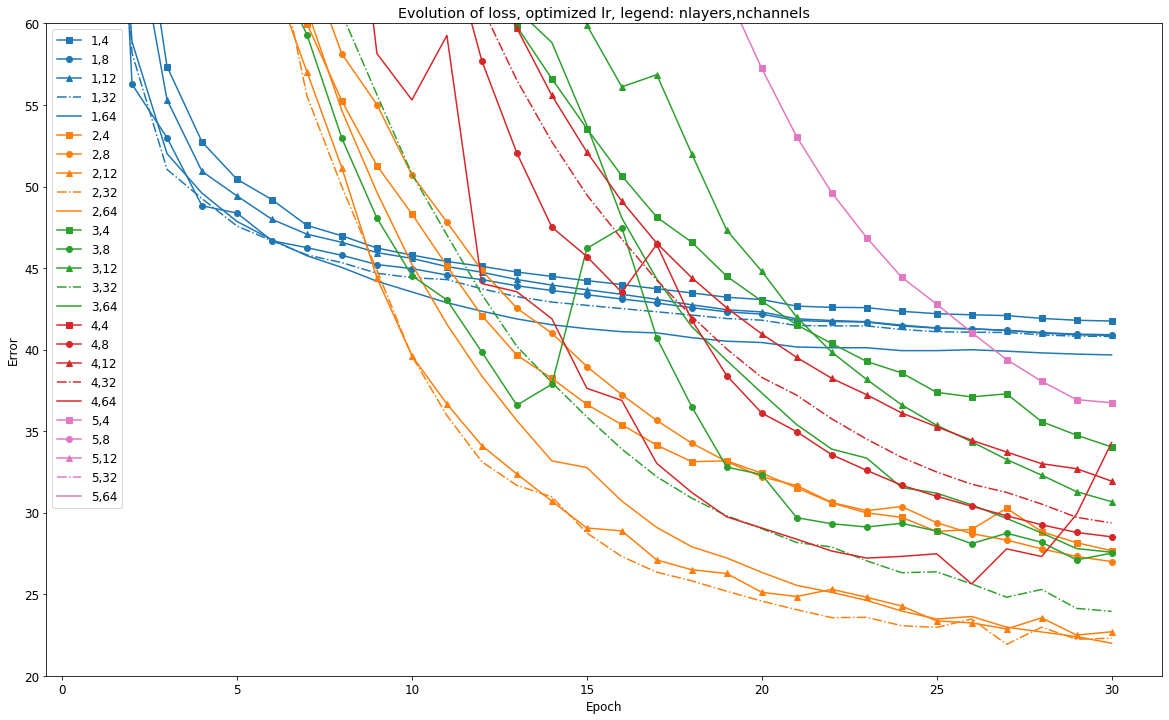

In [17]:
ys = [t[1] for t in all_losses.values()]
plot(range(1, num_epoch+1), ys, labels=list(all_losses.keys()), xlabel='Epoch', ylabel='Error', 
     title='Evolution of loss, optimized lr, legend: nlayers,nchannels',
     styles=['C'+str(c)+'-'+s for c in [0,1,2,3,6] for s in ['s','o','^','.','']],
     yrange=(20, 60), figsize=(20, 12))
plt.savefig('data_generated/week5_errors.png')

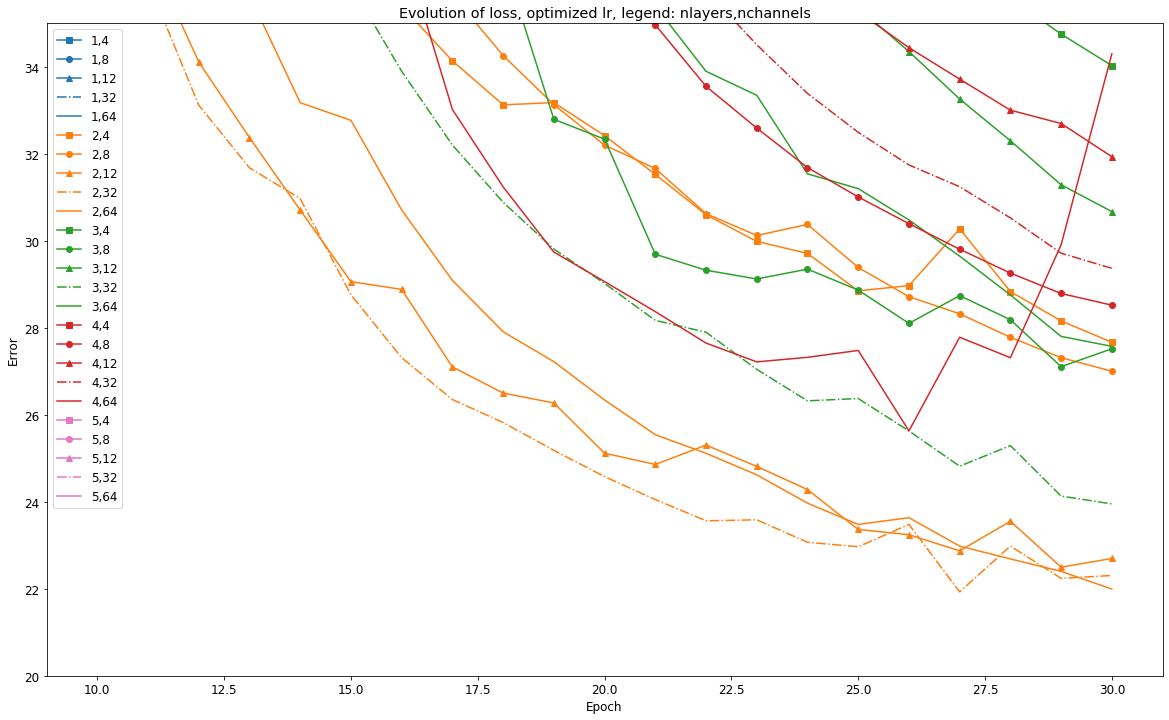

In [13]:
ys = [l[9:] for _, l in all_losses.values()]
plot(range(10, num_epoch+1), ys, labels=list(all_losses.keys()), xlabel='Epoch', ylabel='Error', 
     title='Evolution of loss, optimized lr, legend: nlayers,nchannels',
     styles=['C'+str(c)+'-'+s for c in [0,1,2,3,6] for s in ['s','o','^','.','']],
     yrange=(20, 35), figsize=(20, 12))
plt.savefig('data_generated/week5_errors_zoom.png')

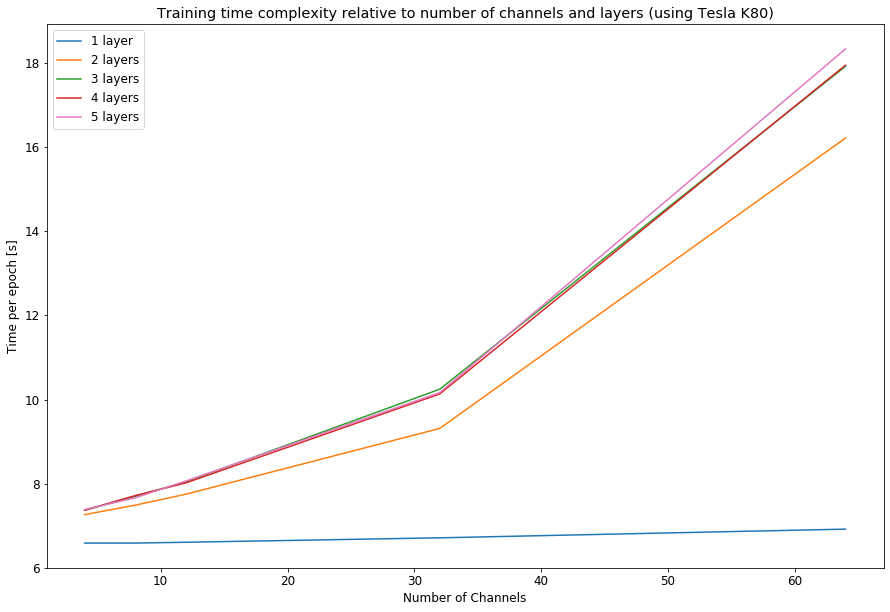

In [14]:
ys = [[time for (k, (time, _)) in all_losses.items() if k[0] == str(nlayers)]
      for nlayers in range(1, 6)]
labels = [f'{i} layers' for i in range(1, 6)]
labels[0] = labels[0][:-1]
plot([4, 8, 12, 32, 64], ys, labels=labels, title='Training time complexity relative to number of channels and layers (using Tesla K80)', xlabel='Number of Channels', ylabel='Time per epoch [s]')
plt.savefig('data_generated/week5_train_time.png')

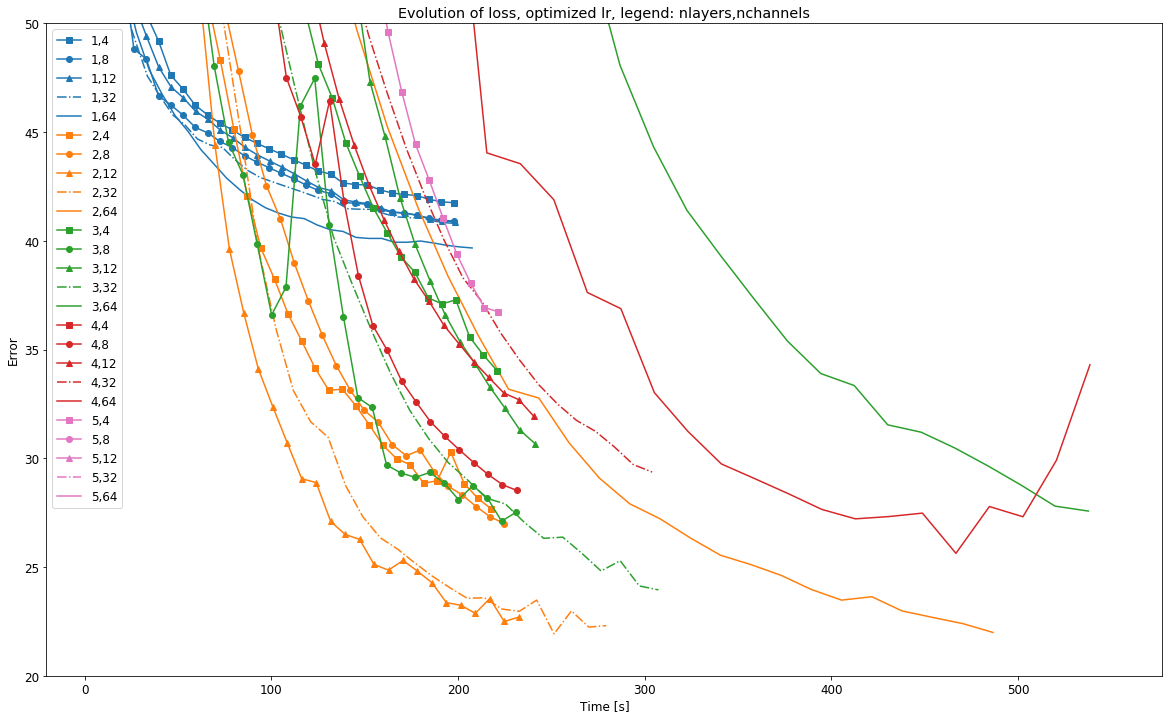

In [15]:
ys = [l for _, l in all_losses.values()]
xs = np.repeat(np.arange(1, 31)[np.newaxis,:], 25, axis=0) * np.array(list(all_losses.values()))[:,0,np.newaxis]
plot(xs, ys, labels=list(all_losses.keys()), xlabel='Time [s]', ylabel='Error', 
     title='Evolution of loss, optimized lr, legend: nlayers,nchannels',
     styles=['C'+str(c)+'-'+s for c in [0,1,2,3,6] for s in ['s','o','^','.','']],
     yrange=(20, 50), figsize=(20, 12))
plt.savefig('data_generated/week5_errors_wrt_time.png')

# TRASH